# An Efficient Analytic Signal Generator

Here an implementation of the FIR filter proposed in the article _An Efficient Analytic Signal Generator_ wich allows to process the analytical signal in a smart and efficient way. With this latter we can esaly and precisely calculate the envelope but also the instantaneous phase which can be usefull un further realease for example to implement doppler imaging. We are going to test this implemetation on a chirp pulse whith parameters chosen from the actual prototype when possible.

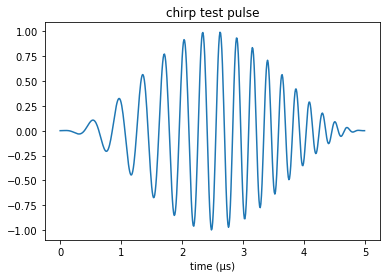

In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt 

fs = 100e6     # sample rate [Hz]
f0 = 3.5e6     # transducer central frequency [Hz]
bandwidth = 1  # transducer bandwidth [%]
tau = 5e-6     # chirp duration [s] - arbitrary since we use pulses   
               # but chirp are better for this demonstration
n = 64         # FIR number of taps - to be chosen depending on acuracy 
               # needed vs processing disponibility
    
# test signal gonna be a chirp windowed by a hanning window
dt = 1/fs
t = np.arange(int(tau/dt))*dt
fmin = f0*(1 - bandwidth/2)
fmax = f0*(1 + bandwidth/2)

x = sp.chirp(t, fmin, tau, fmax) * np.hanning(len(t))

plt.figure()
plt.plot(t/1e-6,x)
plt.xlabel('time (µs)')
plt.title('chirp test pulse')
plt.show()

## Usual Hibert FIR filtering

We design an usual hilbert FIR filter with the window design method. We truncate an ideal infinite filter by multiplying it with a finite length window function.

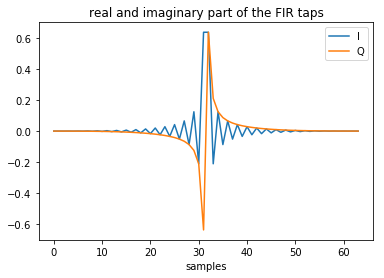

In [2]:
# construct ideal hilbert filter truncated to desired length
fc = 1;
tc = fc/2 * np.arange((1-n)/2,(n+1)/2);

hfilt = np.sinc(tc)*np.exp(1j*np.pi*tc);

# multiply ideal filter with tapered window
beta = 8;
firFilter = hfilt*np.kaiser(n,beta);
firFilter /= np.sum(np.real(firFilter));

plt.plot(np.real(firFilter),label='I')
plt.plot(np.imag(firFilter),label='Q')
plt.xlabel('samples')
plt.title('real and imaginary part of the FIR taps')
plt.legend()
plt.show()

## Rotated Hibert FIR filtering 

As sugested in the article we rotate this complex filter by 45° which mainly allows to half the non null number of the FIR coefficient and bring some kind of nice symmetry with still retaining the same envelope and phase results.  

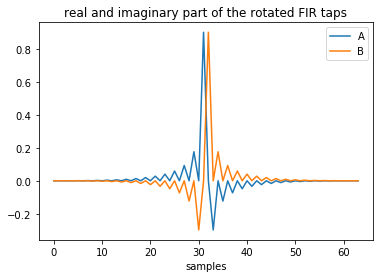

In [3]:
firFilter *= np.exp(1j*np.pi/4)

plt.plot(np.real(firFilter),label='A')
plt.plot(np.imag(firFilter),label='B')
plt.xlabel('samples')
plt.title('real and imaginary part of the rotated FIR taps')
plt.legend()
plt.show()

## Lets Compare !

We filter with the obtain filter and compare with the ideal hilbert transform

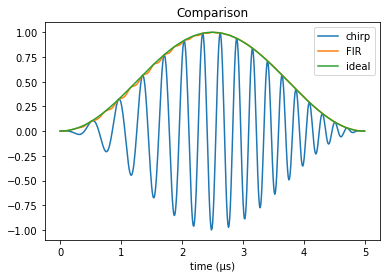

In [4]:
fir = np.abs(np.convolve(x,firFilter,'same'))
hil = np.abs(sp.hilbert(x))

plt.plot(t/1e-6,x,label='chirp')
plt.plot(t/1e-6,fir,label='FIR')
plt.plot(t/1e-6,hil,label='ideal')
plt.xlabel('time (µs)')
plt.title('Comparison')
plt.legend()
plt.show()

It seems to work pretty well ! In the begining it's not perfect. It will be explain latter. The begining of the signal is lower in frequency.

## Filter response

In order to understand the filter imperfection we can plot his frequency response

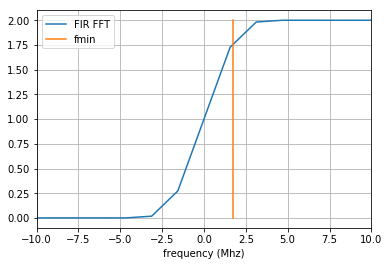

In [5]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(n,dt))/1e6,np.fft.fftshift((np.abs(np.fft.fft(firFilter)))),label='FIR FFT')
plt.plot((fmin/1e6,fmin/1e6),(0,2),label='fmin')
plt.xlim([-10, 10])
plt.legend()
plt.xlabel('frequency (Mhz)')
plt.grid()
plt.show()

We should see a stepped response. We have here an transition band wich must be designed to be smaller than the lowest frequency. In this case it's almost the case but we could incrase the number of taps to reduce the transition band size.

## Performance comparison

In [6]:
%timeit np.convolve(x,firFilter,'same')

10000 loops, best of 3: 113 µs per loop


In [7]:
%timeit np.abs(sp.hilbert(x))

The slowest run took 5.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 97.7 µs per loop


The two seems to run at the same speed on my laptop. But the FIR version has not been optimized to take advantage of the zero coefficent which can be skiped in the calculation. It also depends on the capibilty of a small proc to calculate FFT vs FIR convolution. What do you think ?

## Conclusion

We have calculate ond optimized some FIR coefficients that could be implemented in a DSP in order to calculate the signal envelope. This should be really efficient since DSP are mainly constructed to process FIR filters or those kind of things

Thanks for reading

Alister Trabattoni